In [ ]:
%load_ext autoreload
%autoreload 2
%matplotlib qt

In [ ]:
from examples.Planes.e190 import e190
from ICARUS.Vehicle.plane import Airplane
e190_p: Airplane = e190("EMBRAER_E190_main_wing_flapped")
# e190_p.visualize()

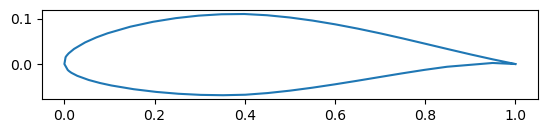

[1.0, 0.95037, 0.90077, 0.85108, 0.80127, 0.75135, 0.70131, 0.65114, 0.60086, 0.55047, 0.5, 0.44945, 0.39885, 0.34823, 0.29763, 0.24707, 0.19657, 0.14617, 0.09595, 0.07095, 0.04609, 0.02152, 0.0095, 0.00486, 0.00263, 0.0, 0.00737, 0.01014, 0.0155, 0.02848, 0.05391, 0.07905, 0.10405, 0.15383, 0.20343, 0.25293, 0.30237, 0.35177, 0.40115, 0.45055, 0.5, 0.54953, 0.59914, 0.64886, 0.69869, 0.74865, 0.79873, 0.84892, 0.94963, 1.0]


ValueError: could not convert string to float: '64418_flapped'

In [2]:
from ICARUS.Airfoils.airfoilD import AirfoilD
from ICARUS.Database import DB2D, XFLRDB
import os
naca64418: AirfoilD = AirfoilD.load_from_file(os.path.join(XFLRDB, 'naca64418.dat'))
naca64418_fl: AirfoilD = AirfoilD.load_from_file(os.path.join(DB2D,"NACA64418_flapped", 'naca64418_flapped'))
# naca64418_fl: AirfoilD = naca64418.flap_airfoil(0.75, 1.3, 35)

In [ ]:
naca64418.fix_le()

# Load Foil Data

In [ ]:
from ICARUS.Software.XFLR5.polars import read_polars_2d
from ICARUS.Database.db import DB
from ICARUS.Core.struct import Struct
from ICARUS.Database import XFLRDB

In [ ]:
db = DB()
foildb = db.foilsDB
foildb.load_data()
read_polars_2d(foildb,XFLRDB)
airfoils: Struct = foildb.set_available_airfoils()

In [ ]:
airfoils.keys()

In [ ]:
from ICARUS.Airfoils.airfoilD import AirfoilD
naca64418: AirfoilD = db.foilsDB.set_available_airfoils()["NACA64418"]
naca64418_fl: AirfoilD = naca64418.flap_airfoil(0.75, 1.3, 35)

# Get Plane

In [ ]:
from examples.Planes.hermes import hermes
from ICARUS.Vehicle.plane import Airplane
# airplane = hermes(airfoils ,"Hermes")
from ICARUS.Software.XFLR5.parser import parse_xfl_project
filename: str = "Data/XFLR5/embraer_cruise.xml"
airplane: Airplane = parse_xfl_project(filename)

airplane.name = "Embraer_E190_Cruise"
airplane.visualize()


# airplane.save()

# Import Enviroment

In [ ]:
from ICARUS.Enviroment.definition import EARTH

# Get Solver

In [ ]:
from ICARUS.Software.GenuVP.gnvp3 import get_gnvp3
gnvp3 = get_gnvp3(db)
print(gnvp3)

## AoA Run

In [ ]:
analysis: str = gnvp3.available_analyses_names()[1] # ANGLES PARALLEL
print(f"Selecting Analysis: {analysis}")
gnvp3.set_analyses(analysis)
options: Struct = gnvp3.get_analysis_options(verbose=True)
solver_parameters: Struct = gnvp3.get_solver_parameters(verbose=True)

In [ ]:
AoAmin = -6
AoAmax = 8
NoAoA = (AoAmax - AoAmin) + 1
angles = np.linspace(AoAmin, AoAmax, NoAoA, dtype= float)
u_freestream = 20
# airplane.define_dynamic_pressure(u_freestream, EARTH.air_density)

options.plane.value         = airplane
options.environment.value   = EARTH
options.db.value            = db
options.solver2D.value      = 'XFLR'
options.maxiter.value       = 100
options.timestep.value      = 1e-2
options.u_freestream.value  = u_freestream
options.angles.value        = angles

solver_parameters.Use_Grid.value = 0

gnvp3.print_analysis_options()
gnvp3.run()
polars = gnvp3.get_results()
airplane.save()

# Dynamics

### Define and Trim Plane

In [ ]:
from ICARUS.Flight_Dynamics.state import State
if isinstance(polars,int):
    raise Exception("No Polars")
unstick = State("Unstick",airplane,polars,EARTH)

### Pertrubations

In [ ]:
unstick.add_all_pertrubations("Central")
unstick.get_pertrub()

In [ ]:
analysis = gnvp3.available_analyses_names(verbose=True)[4] # ANGLES PARALLEL
print(f"Selecting Analysis: {analysis}")
gnvp3.set_analyses(analysis)
options = gnvp3.get_analysis_options(verbose=True)

In [ ]:
options.plane.value         = airplane
options.state.value         = unstick
options.environment.value   = EARTH
options.db.value            = db
options.solver2D.value      = 'XFLR'
options.maxiter.value       = 200
options.timestep.value      = 5e-3
options.u_freestream.value  = unstick.trim['U']
options.angle.value        = unstick.trim['AoA']

gnvp3.print_analysis_options()
gnvp3.run()
gnvp3.get_results()
unstick.save()

# Sensitivity Analysis

In [ ]:
# if sensAnalysisGNVP3 :
#     for var in ['u','w','q','theta','v','p','r','phi']:
#         space = np.logspace(np.log10(0.00001), np.log10(1), 10, base=10)
#         space =[*-space,*space]
#         maxiter = 2
#         timestep = 5e-2
#         dyn.sensitivityAnalysis(var, space)
#         GNVP3BatchArgs = [dyn, var, foildb, "Xfoil",
#                         maxiter, timestep,
#                         dyn.trim['U'], dyn.trim['AoA']]
#         dyn.runAnalysis(runGNVPsensitivityParallel, GNVP3BatchArgs)
#         perDIR = os.path.join(dyn.CASEDIR, f"Sensitivity_{var}")
#         dyn.sensResults[var] = pertrResults(perDIR, HOMEDIR)
#     dyn.save()